 ## 1. Introduction


1. Identify and visualize which factors contribute to customer churn:
    
2. Build a prediction model that will perform the following:
    * Classify if a customer is going to churn or not
    * Preferably and based on model performance, choose a model that will attach a probability to the churn to make it easier for customer service to target low hanging fruits in their efforts to prevent churn

## 2. Data set review & preparation

In this section we will seek to explore the structure of our data: 
1. To understand the input space the data set
2. And to prepare the sets for exploratory and prediction tasks as described in section 1

In [69]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [70]:
# Read the data frame
df = pd.read_csv('./Churn_Modelling.csv', delimiter=',')
df.shape

(10000, 14)

In [71]:
#0 null columns! 
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Well isn't that a rare find; no missing values! 

In [72]:
# Get unique count for each variable
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

From the above, a couple of question linger:
1. The data appears to be a snapshot as some point in time e.g. the balance is for a given date which leaves a lot of questions:
    * What date is it and of what relevance is this date
    * Would it be possible to obtain balances over a period of time as opposed to a single date.
2. There are customers who have exited but still have a balance in their account! What would this mean? Could they have exited from a product and not the bank?
3. What does being an active member mean and are there difference degrees to it? Could it be better to provide transaction count both in terms of credits and debits to the account instead?
4. A break down to the products bought into by a customer could provide more information topping listing of product count

For this exercise, we proceed to model without context even though typically having context and better understanding of the data extraction process would give better insight and possibly lead to better and contextual results of the modelling process

In [73]:
# Check variable data types
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

So we moslty have categorical variables and 5 continuous variables

## 3. Exploratory Data Analysis
Here our main interest is to get an understanding as to how the given attributes relate too the 'Exit' status.

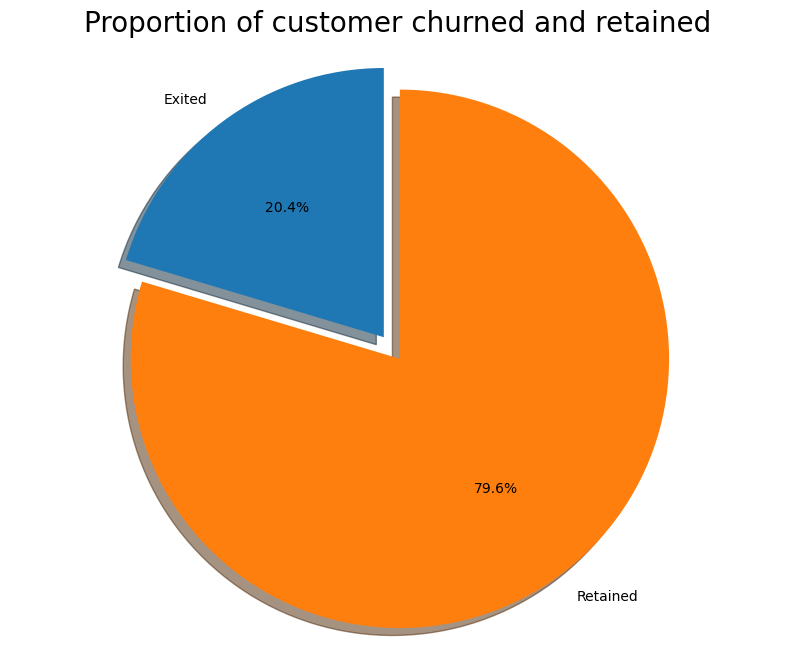

In [74]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

So about 20% of the customers have churned. So the baseline model could be to predict that 20% of the customers will churn.
Given 20% is a small number,  we need to ensure that the chosen model does predict with great accuracy this 20% as it is of interest to the bank to identify and keep this bunch as opposed to accurately predicting the customers that are retained.

<Axes: xlabel='IsActiveMember', ylabel='count'>

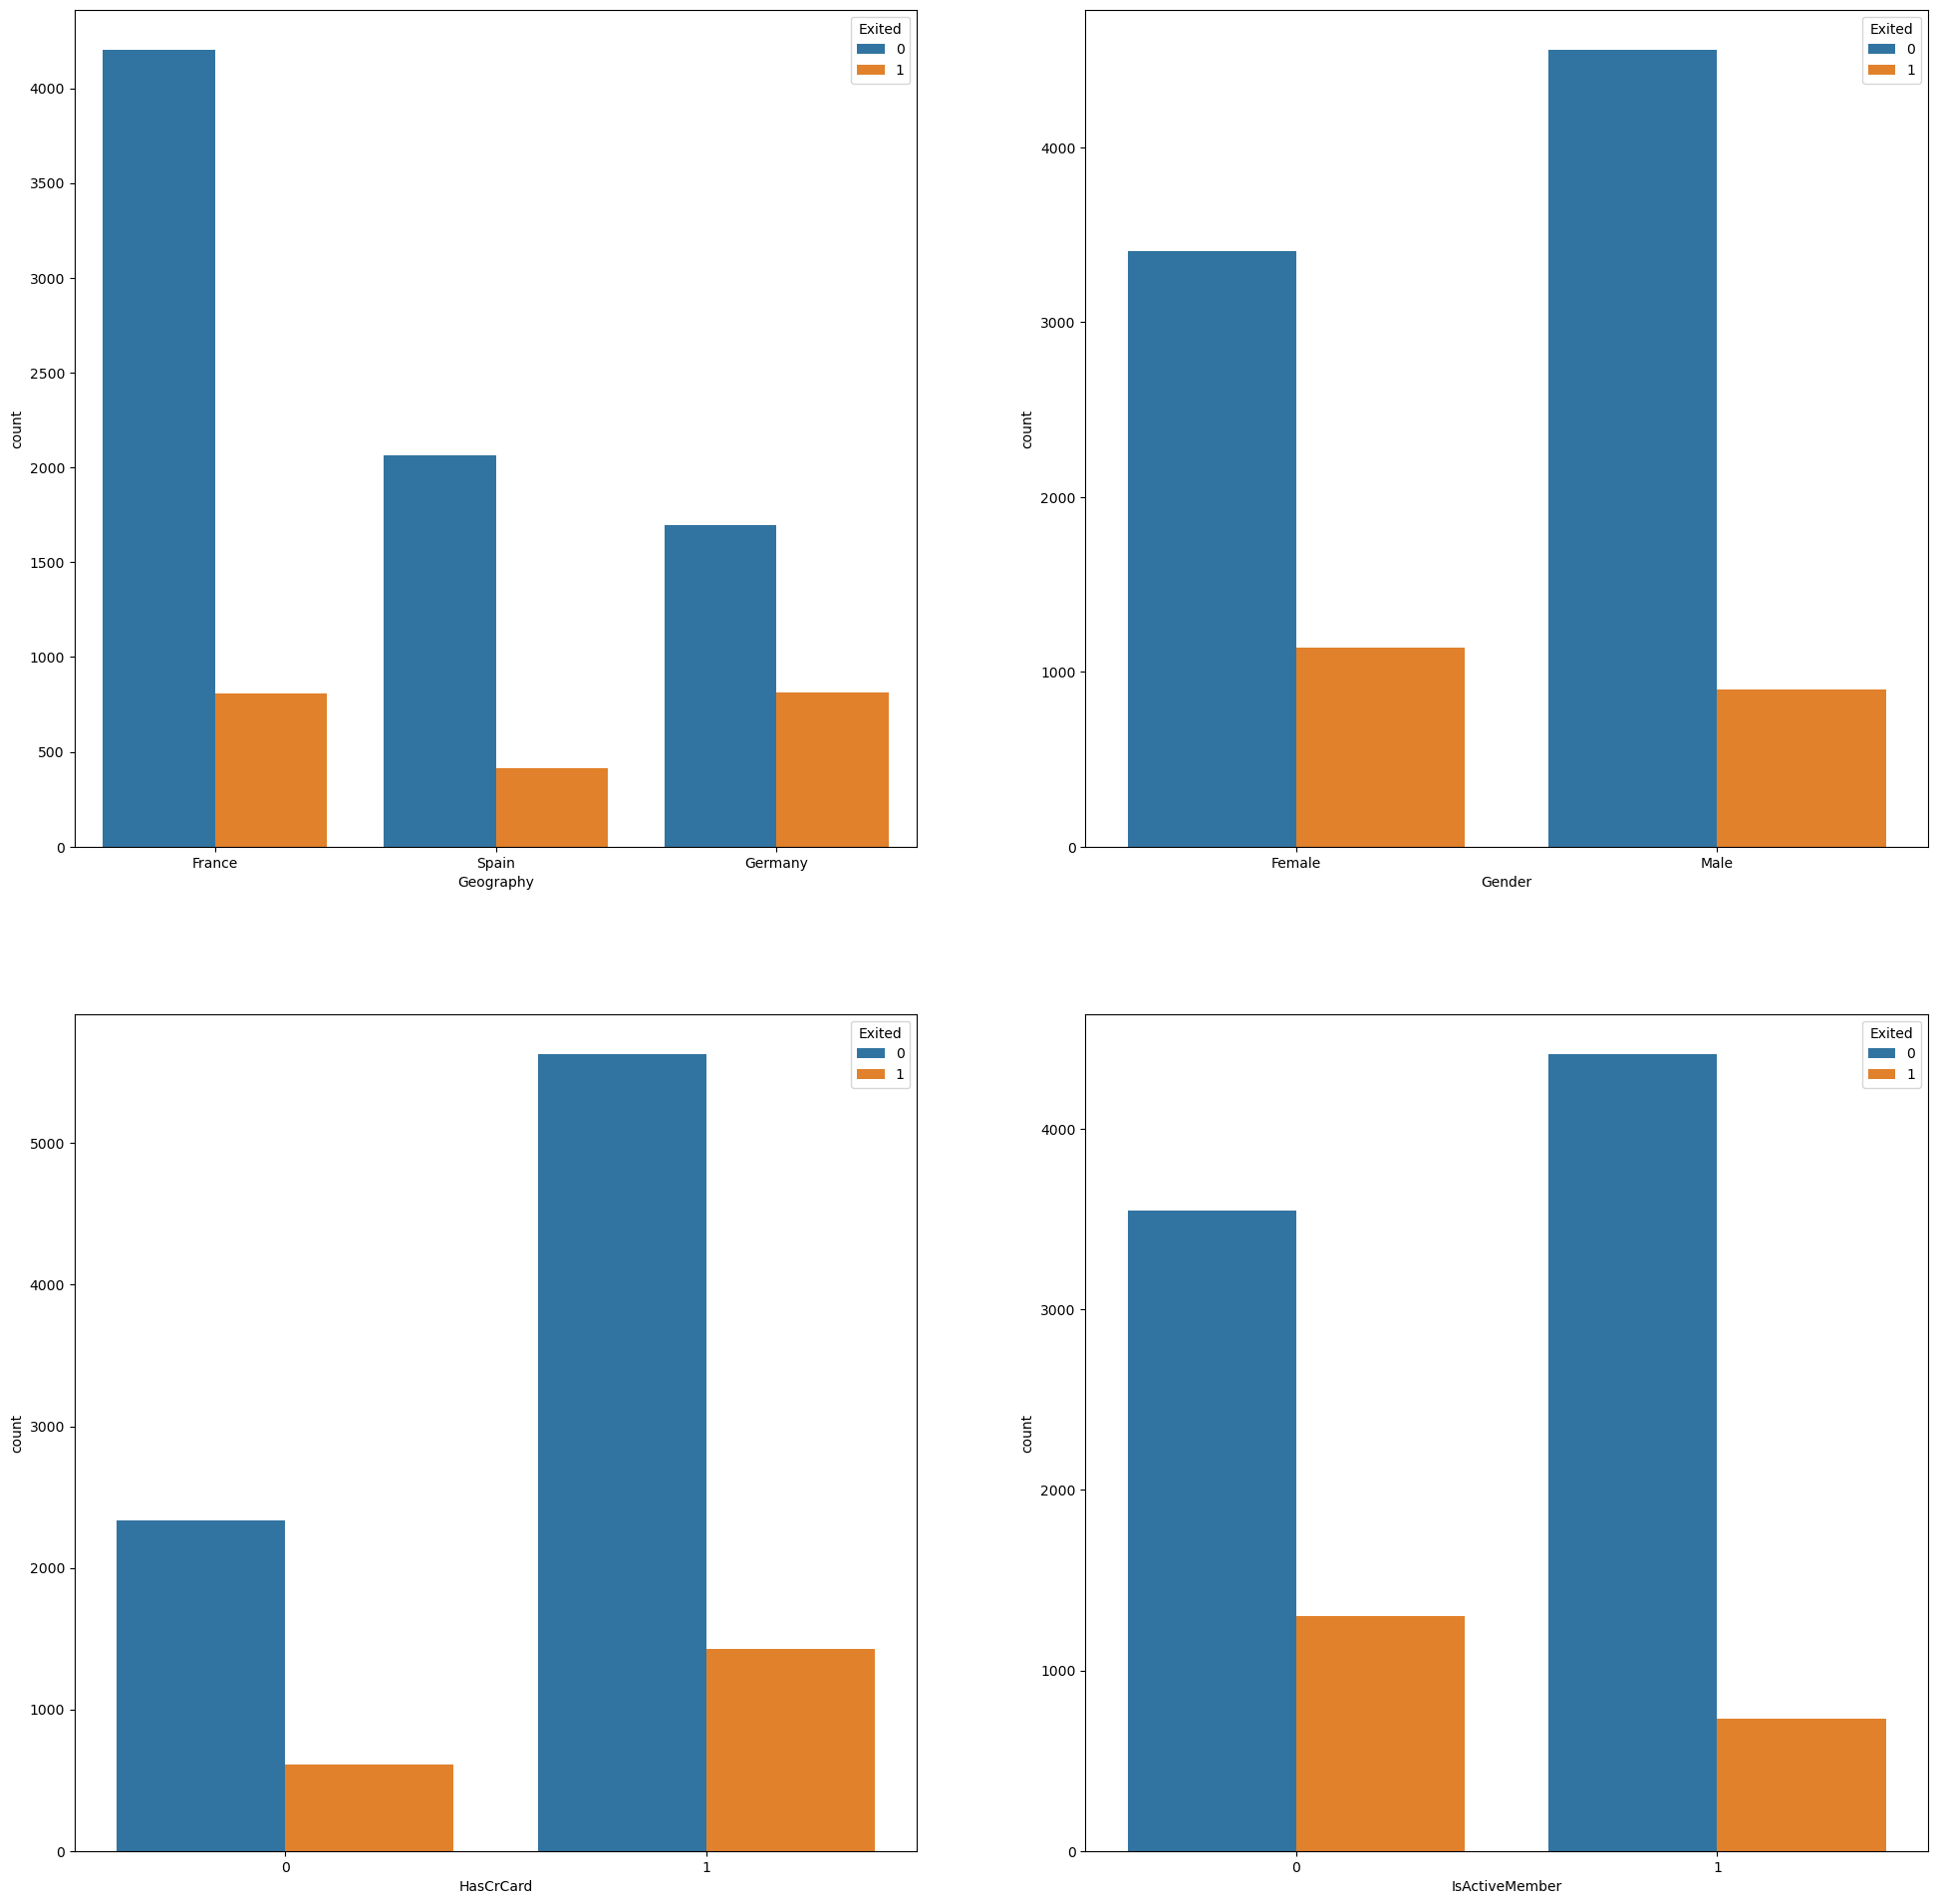

In [75]:
    # We first review the 'Status' relation with categorical variables
    fig, axarr = plt.subplots(2, 2, figsize=(24, 24))
    sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
    sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
    sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
    sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

We note the following:
* Majority of the data is from persons from France. However, the proportion of churned customers is with inversely related to the population of customers alluding to the bank possibly having a problem (maybe not enough customer service resources allocated) in the areas where it has fewer clients.
* The proportion of female customers churning is also greater than that of male customers
* Interestingly, majority of the customers that churned are those with credit cards. Given that majority of the customers have credit cards could prove this to be just a coincidence. 
* Unsurprisingly the inactive members have a greater churn. Worryingly is that the overall proportion of inactive mebers is quite high suggesting that the bank may need a program implemented to turn this group to active customers as this will definately have a positive impact on the customer churn.


<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

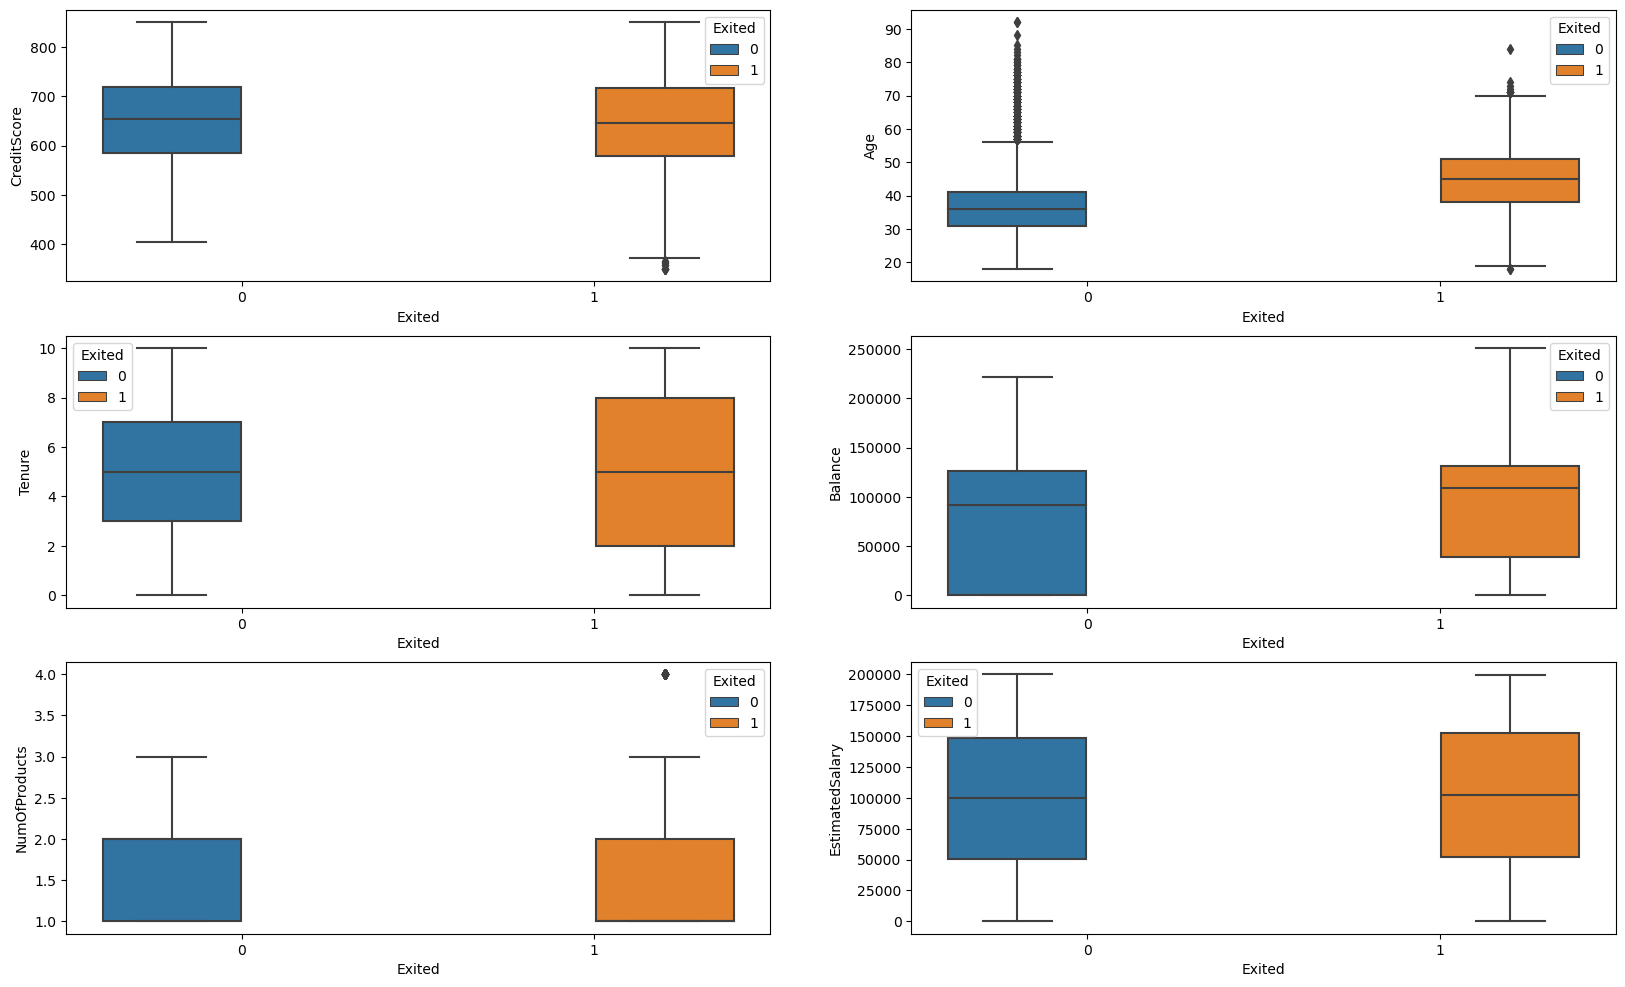

In [76]:
    # Relations based on the continuous data attributes
    fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
    sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
    sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
    sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
    sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
    sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
    sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

We note the following:
* There is no significant difference in the credit score distribution between retained and churned customers. 
* The older customers are churning at more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review their target market or review the strategy for retention between the different age groups
* With regard to the tenure, the clients on either extreme end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure.
*  Worryingly, the bank is losing customers with significant bank balances which is likely to hit their available capital for lending.
* Neither the product nor the salary has a significant effect on the likelihood to churn.

## 4. Feature engineering
We seek to add features that are likely to have an impact on the probability of churning. We first split the train and test sets

In [77]:
# Split Train, test data
df_train = df.sample(frac=0.8,random_state=200)
df_test = df.drop(df_train.index)
print(len(df_train))
print(len(df_test))

8000
2000


(-1.0, 5.0)

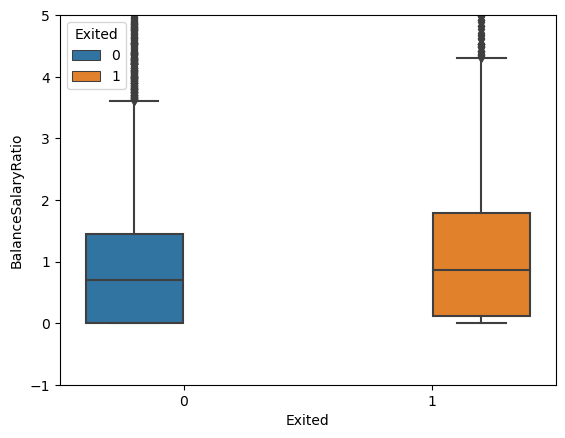

In [78]:
df_train['BalanceSalaryRatio'] = df_train.Balance/df_train.EstimatedSalary
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 5)

we have seen that the salary has little effect on the chance of a customer churning. However as seen above, the ratio of the bank balance and the estimated salary indicates that customers with a higher balance salary ratio churn more which would be worrying to the bank as this impacts their source of loan capital.

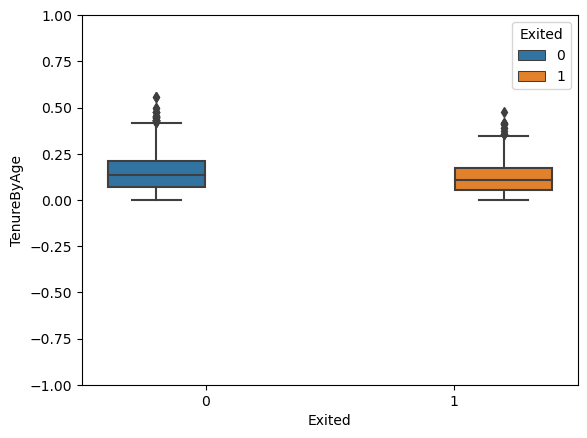

In [79]:
# Given that tenure is a 'function' of age, we introduce a variable aiming to standardize tenure over age:
df_train['TenureByAge'] = df_train.Tenure/(df_train.Age)
sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 1)
plt.show()

In [80]:
'''Lastly we introduce a variable to capture credit score given age to take into account credit behaviour visavis adult life
:-)'''
df_train['CreditScoreGivenAge'] = df_train.CreditScore/(df_train.Age)

In [81]:
# Resulting Data Frame
df_train.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
8159,8160,15637427,Lu,461,Spain,Female,25,6,0.00,2,1,1,15306.29,0,0.000000,0.240000,18.440000
6332,6333,15793046,Holden,619,France,Female,35,4,90413.12,1,1,1,20555.21,0,4.398550,0.114286,17.685714
8895,8896,15658972,Foster,699,France,Female,40,8,122038.34,1,1,0,102085.35,0,1.195454,0.200000,17.475000
5351,5352,15679048,Koger,558,Germany,Male,41,2,124227.14,1,1,1,111184.67,0,1.117305,0.048780,13.609756
4314,4315,15582276,Greco,638,France,Male,34,5,133501.36,1,0,1,155643.04,0,0.857741,0.147059,18.764706


## 5. Data prep for model fitting

In [82]:
# Arrange columns by data type for easier manipulation
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
df_train = df_train[['Exited'] + continuous_vars + cat_vars]
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,0,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,0,1,France,Male


In [83]:
'''For the one hot variables, we change 0 to -1 so that the models can capture a negative relation 
where the attribute in inapplicable instead of 0'''
df_train.loc[df_train.HasCrCard == 0, 'HasCrCard'] = -1
df_train.loc[df_train.IsActiveMember == 0, 'IsActiveMember'] = -1
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,-1,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,-1,1,France,Male


In [84]:
# One hot encode the categorical variables
lst = ['Geography', 'Gender']
remove = list()
for i in lst:
    if (df_train[i].dtype == str or df_train[i].dtype == object):
        for j in df_train[i].unique():
            df_train[i+'_'+j] = np.where(df_train[i] == j,1,-1)
        remove.append(i)
df_train = df_train.drop(remove, axis=1)
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_Spain,Geography_France,Geography_Germany,Gender_Female,Gender_Male
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,1,-1,-1,1,-1
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,-1,1,-1,1,-1
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,-1,-1,1,-1,1,-1
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,-1,-1,1,-1,1
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,-1,1,-1,1,-1,-1,1


In [85]:
# minMax scaling the continuous variables
minVec = df_train[continuous_vars].min().copy()
maxVec = df_train[continuous_vars].max().copy()
df_train[continuous_vars] = (df_train[continuous_vars]-minVec)/(maxVec-minVec)
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_Spain,Geography_France,Geography_Germany,Gender_Female,Gender_Male
8159,0,0.222,0.094595,0.6,0.000000,0.333333,0.076118,0.000000,0.432000,0.323157,1,1,1,-1,-1,1,-1
6332,0,0.538,0.229730,0.4,0.360358,0.000000,0.102376,0.003317,0.205714,0.305211,1,1,-1,1,-1,1,-1
8895,0,0.698,0.297297,0.8,0.486406,0.000000,0.510225,0.000901,0.360000,0.300198,1,-1,-1,1,-1,1,-1
5351,0,0.416,0.310811,0.2,0.495130,0.000000,0.555744,0.000843,0.087805,0.208238,1,1,-1,-1,1,-1,1
4314,0,0.576,0.216216,0.5,0.532094,0.000000,0.778145,0.000647,0.264706,0.330882,-1,1,-1,1,-1,-1,1


In [86]:
# data prep pipeline for test data
def DfPrepPipeline(df_predict,df_train_Cols,minVec,maxVec):
    # Add new features
    df_predict['BalanceSalaryRatio'] = df_predict.Balance/df_predict.EstimatedSalary
    df_predict['TenureByAge'] = df_predict.Tenure/(df_predict.Age - 18)
    df_predict['CreditScoreGivenAge'] = df_predict.CreditScore/(df_predict.Age - 18)
    # Reorder the columns
    continuous_vars = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
    cat_vars = ['HasCrCard','IsActiveMember',"Geography", "Gender"] 
    df_predict = df_predict[['Exited'] + continuous_vars + cat_vars]
    # Change the 0 in categorical variables to -1
    df_predict.loc[df_predict.HasCrCard == 0, 'HasCrCard'] = -1
    df_predict.loc[df_predict.IsActiveMember == 0, 'IsActiveMember'] = -1
    # One hot encode the categorical variables
    lst = ["Geography", "Gender"]
    remove = list()
    for i in lst:
        for j in df_predict[i].unique():
            df_predict[i+'_'+j] = np.where(df_predict[i] == j,1,-1)
        remove.append(i)
    df_predict = df_predict.drop(remove, axis=1)
    # Ensure that all one hot encoded variables that appear in the train data appear in the subsequent data
    L = list(set(df_train_Cols) - set(df_predict.columns))
    for l in L:
        df_predict[str(l)] = -1        
    # MinMax scaling coontinuous variables based on min and max from the train data
    df_predict[continuous_vars] = (df_predict[continuous_vars]-minVec)/(maxVec-minVec)
    # Ensure that The variables are ordered in the same way as was ordered in the train set
    df_predict = df_predict[df_train_Cols]
    return df_predict

## 6. Model fitting and selection
For the model fitting, I will try out the following
* Logistic regression in the primal space and with different kernels
* SVM in the primal and with different Kernels
* Ensemble models

In [87]:
!pip install xgboost
import xgboost

# Support functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# Fit models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Scoring functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [88]:
# Function to give best model score and parameters
def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)

In [89]:
# Fit primal logistic regression
param_grid = {'C': [0.1,0.5,1,10,50,100], 'max_iter': [250], 'fit_intercept':[True],'intercept_scaling':[1],
              'penalty':['l2'], 'tol':[0.00001,0.0001,0.000001]}
log_primal_Grid = GridSearchCV(LogisticRegression(solver='lbfgs'),param_grid, cv=10, refit=True, verbose=0)
log_primal_Grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(log_primal_Grid)

0.8149999999999998
{'C': 100, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'penalty': 'l2', 'tol': 1e-05}
LogisticRegression(C=100, max_iter=250, tol=1e-05)


In [90]:
# Fit logistic regression with degree 2 polynomial kernel
param_grid = {'C': [0.1,10,50], 'max_iter': [300,500], 'fit_intercept':[True],'intercept_scaling':[1],'penalty':['l2'],
              'tol':[0.0001,0.000001]}
poly2 = PolynomialFeatures(degree=2)
df_train_pol2 = poly2.fit_transform(df_train.loc[:, df_train.columns != 'Exited'])
log_pol2_Grid = GridSearchCV(LogisticRegression(solver = 'liblinear'),param_grid, cv=5, refit=True, verbose=0)
log_pol2_Grid.fit(df_train_pol2,df_train.Exited)
best_model(log_pol2_Grid)

0.8553750000000001
{'C': 50, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 300, 'penalty': 'l2', 'tol': 0.0001}
LogisticRegression(C=50, max_iter=300, solver='liblinear')


In [91]:
# Fit SVM with RBF Kernel
param_grid = {'C': [0.5,100,150], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['rbf']}
SVM_grid = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=0)
SVM_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(SVM_grid)

0.8518747609662071
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
SVC(C=100, gamma=0.1, probability=True)


In [92]:
# Fit SVM with pol kernel
param_grid = {'C': [0.5,1,10,50,100], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['poly'],'degree':[2,3] }
SVM_grid = GridSearchCV(SVC(), param_grid, cv=3, refit=True, verbose=0)
SVM_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(SVM_grid)

0.8544999485716948
{'C': 100, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly', 'probability': True}
SVC(C=100, degree=2, gamma=0.1, kernel='poly', probability=True)


In [93]:
# Fit random forest classifier
param_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [2,4,6,7,8,9],'n_estimators':[50,100],'min_samples_split': [3, 5, 6, 7]}
RanFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, refit=True, verbose=0)
RanFor_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(RanFor_grid)

0.8632500000000001
{'max_depth': 8, 'max_features': 6, 'min_samples_split': 7, 'n_estimators': 100}
RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=7)


In [94]:
# Fit Extreme Gradient boosting classifier
param_grid = {'max_depth': [5,6,7,8], 'gamma': [0.01,0.001,0.001],'min_child_weight':[1,5,10], 'learning_rate': [0.05,0.1, 0.2, 0.3], 'n_estimators':[5,10,20,100]}
xgb_grid = GridSearchCV(XGBClassifier(), param_grid, cv=5, refit=True, verbose=0)
xgb_grid.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)
best_model(xgb_grid)

0.8626250000000001
{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


### Fit best Models

In [96]:
# Fit primal logistic regression
log_primal = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=250, multi_class='auto',n_jobs=None, 
                                penalty='l2', random_state=None, solver='lbfgs',tol=1e-05, verbose=0, warm_start=False)
log_primal.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

LogisticRegression(C=100, max_iter=250, tol=1e-05)

In [99]:
# Fit logistic regression with pol 2 kernel
poly2 = PolynomialFeatures(degree=2)
df_train_pol2 = poly2.fit_transform(df_train.loc[:, df_train.columns != 'Exited'])
log_pol2 = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=300, multi_class='auto', n_jobs=None, 
                              penalty='l2', random_state=None, solver='liblinear',tol=0.0001, verbose=0, warm_start=False)
log_pol2.fit(df_train_pol2,df_train.Exited)

LogisticRegression(C=10, max_iter=300, solver='liblinear')

In [100]:
# Fit SVM with RBF Kernel
SVM_RBF = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf', max_iter=-1, probability=True, 
              random_state=None, shrinking=True,tol=0.001, verbose=False)
SVM_RBF.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

SVC(C=100, gamma=0.1, probability=True)

In [101]:
# Fit SVM with Pol Kernel
SVM_POL = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,  decision_function_shape='ovr', degree=2, gamma=0.1, kernel='poly',  max_iter=-1,
              probability=True, random_state=None, shrinking=True, tol=0.001, verbose=False)
SVM_POL.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

SVC(C=100, degree=2, gamma=0.1, kernel='poly', probability=True)

In [103]:
# Fit Random Forest classifier
RF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',max_depth=8, max_features=6, max_leaf_nodes=None,min_impurity_decrease=0.0
                            ,min_samples_leaf=1, min_samples_split=3,min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
                            oob_score=False, random_state=None, verbose=0,warm_start=False)
RF.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3,
                       n_estimators=50)

In [104]:
# Fit Extreme Gradient Boost Classifier
XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,max_depth=7,
                    min_child_weight=5, missing=None, n_estimators=20,n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,reg_alpha=0, 
                    reg_lambda=1, scale_pos_weight=1, seed=None, silent=True, subsample=1)
XGB.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited)

/Users/dannyliu/.conda/envs/stock_prediction_keras_LSTM/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:37:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.01,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=7, max_leaves=None, min_child_weight=5, missing=None,
              monotone_constraints=None, multi_strategy=None, n_estimators=20,
              n_jobs=1, nthread=None, num_parallel_tree=None, ...)

### Review best model fit accuracy : Keen interest is on the performance in predicting 1's (Customers who churn)

In [105]:
print(classification_report(df_train.Exited, log_primal.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      6353
           1       0.64      0.24      0.35      1647

    accuracy                           0.82      8000
   macro avg       0.73      0.60      0.62      8000
weighted avg       0.79      0.82      0.78      8000



In [106]:
print(classification_report(df_train.Exited,  log_pol2.predict(df_train_pol2)))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6353
           1       0.77      0.46      0.57      1647

    accuracy                           0.86      8000
   macro avg       0.82      0.71      0.75      8000
weighted avg       0.85      0.86      0.85      8000



In [107]:
print(classification_report(df_train.Exited,  SVM_RBF.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6353
           1       0.85      0.40      0.54      1647

    accuracy                           0.86      8000
   macro avg       0.86      0.69      0.73      8000
weighted avg       0.86      0.86      0.84      8000



In [108]:
print(classification_report(df_train.Exited,  SVM_POL.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      6353
           1       0.84      0.38      0.52      1647

    accuracy                           0.86      8000
   macro avg       0.85      0.68      0.72      8000
weighted avg       0.85      0.86      0.83      8000



In [109]:
print(classification_report(df_train.Exited,  RF.predict(df_train.loc[:, df_train.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      6353
           1       0.89      0.51      0.65      1647

    accuracy                           0.89      8000
   macro avg       0.89      0.75      0.79      8000
weighted avg       0.89      0.89      0.88      8000




### Given that in the data we only had 20% of churn, a recall greater than this baseline will already be an improvement but we want to get as high as possible while trying to maintain a high precision so that the bank can train its resources effectively towards clients highlighted by the model without wasting too much resources on the false positives.

### From the review of the fitted models above, the best model that gives a decent balance of the recall and precision is the random forest where according to the fit on the training set, with a precision score on 1's of 0.88, out of all customers that the model thinks will churn, 88% do actually churn and with the recall score of 0.53 on the 1's, the model is able to highlight 53% of all those who churned.

### Test model prediction accuracy on test data

In [115]:
# Make the data transformation for test data
df_test = DfPrepPipeline(df_test,df_train.columns,minVec,maxVec)
df_test = df_test.mask(np.isinf(df_test))
df_test = df_test.dropna()
df_test.shape

/var/folders/m5/cx4hwql56m5_7gzqnfv0v5q80000gn/T/ipykernel_53330/931878692.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict[i+'_'+j] = np.where(df_predict[i] == j,1,-1)
/var/folders/m5/cx4hwql56m5_7gzqnfv0v5q80000gn/T/ipykernel_53330/931878692.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict[i+'_'+j] = np.where(df_predict[i] == j,1,-1)


(1996, 17)

In [116]:
print(classification_report(df_test.Exited,  RF.predict(df_test.loc[:, df_test.columns != 'Exited'])))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1607
           1       0.81      0.39      0.53       389

    accuracy                           0.86      1996
   macro avg       0.84      0.69      0.72      1996
weighted avg       0.86      0.86      0.84      1996



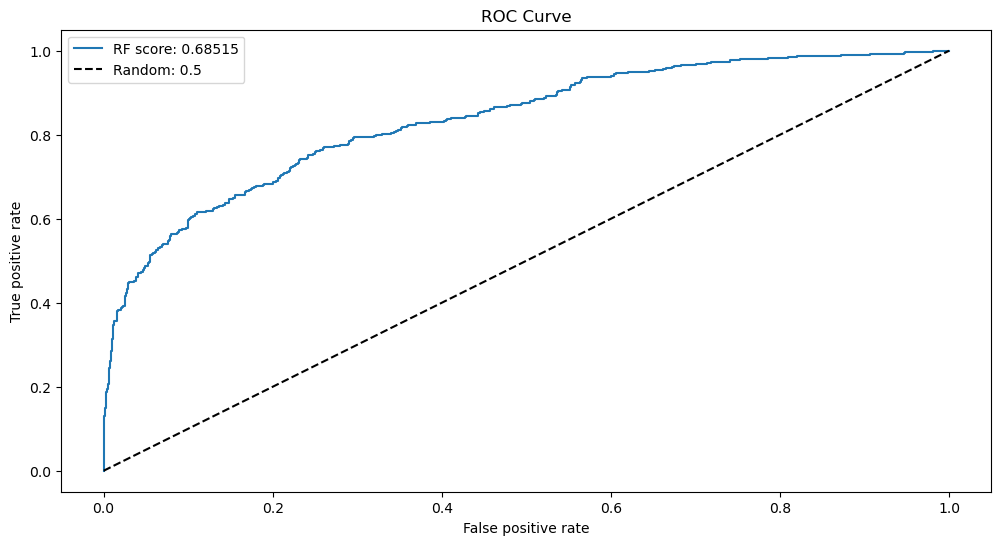

In [117]:
auc_RF_test, fpr_RF_test, tpr_RF_test = get_auc_scores(df_test.Exited, RF.predict(df_test.loc[:, df_test.columns != 'Exited']),
                                                       RF.predict_proba(df_test.loc[:, df_test.columns != 'Exited'])[:,1])
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_RF_test, tpr_RF_test, label = 'RF score: ' + str(round(auc_RF_test, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()